<a href="https://colab.research.google.com/github/Tuesdaythe13th/Tuesdaythe13th/blob/main/Extremism_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
import cv2
import numpy as np
import logging
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Configure paths and parameters
IMAGE_SIZE = (128, 128)
N_COMPONENTS = 50
N_CLUSTERS = 2
DATA_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/data'
MODEL_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/models'
OUTPUT_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/output'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Set up logging
logger = logging.getLogger("ExtremismDetection")
logger.setLevel(logging.INFO)


In [20]:
# Install all required packages (latest versions)
!pip install --quiet opencv-python-headless scikit-learn pandas numpy adversarial-robustness-toolbox tqdm


In [2]:
# Install required packages and upgrade pip/setuptools to the latest versions
!pip install --upgrade pip setuptools && pip install --quiet tensorflow opencv-python-headless pillow scikit-learn numpy tqdm adversarial-robustness-toolbox


In [3]:
import os
import zipfile
import shutil
import logging
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [4]:
# Define the path to the EXTREMISM_MODEL directory
PROJECT_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
MODEL_DIR = os.path.join(PROJECT_DIR, 'models')
OUTPUT_DIR = os.path.join(PROJECT_DIR, 'output')
LOG_DIR = os.path.join(PROJECT_DIR, 'logs')

# Create directories if they don’t exist
dirs = [DATA_DIR, TRAIN_DIR, TEST_DIR, MODEL_DIR, OUTPUT_DIR, LOG_DIR]
for dir_path in dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Created or verified directory: {dir_path}")


Created or verified directory: /content/drive/MyDrive/EXTREMISM_MODEL/data
Created or verified directory: /content/drive/MyDrive/EXTREMISM_MODEL/data/train
Created or verified directory: /content/drive/MyDrive/EXTREMISM_MODEL/data/test
Created or verified directory: /content/drive/MyDrive/EXTREMISM_MODEL/models
Created or verified directory: /content/drive/MyDrive/EXTREMISM_MODEL/output
Created or verified directory: /content/drive/MyDrive/EXTREMISM_MODEL/logs


In [21]:
import os  # Ensure `os` is imported to work with file paths

# Define the path to the EXTREMISM_MODEL directory
EXTREMISM_MODEL_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL'

# List contents of the EXTREMISM_MODEL folder to verify file names and paths
print("Contents of EXTREMISM_MODEL:", os.listdir(EXTREMISM_MODEL_DIR))


Contents of EXTREMISM_MODEL: ['Test_data.zip', 'Training_data.zip', 'data', 'models', 'output', 'logs']


In [5]:
from datetime import datetime

# Set up logging
log_path = os.path.join(LOG_DIR, f"training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger("ExtremismDetection")


In [6]:
print("Training data files:", os.listdir(TRAIN_DIR)[:5])
print("Test data files:", os.listdir(TEST_DIR)[:5])


Training data files: ['nIudt450auYI13_j.jpg', 'photo_17@04-10-2023_20-08-22.jpg', 'photo_42@20-03-2021_10-55-47.jpg', '454721464_360016917149242_1994024034898316304_n.jpg', 'Wttew8gl7lKCZcdF.jpg']
Test data files: ['pitbull_f00f22ec4c 2.png', 'irminsul_c09ee27cda.png', 'lorraine_a8a8c14bac 3.png', 'JzwDeh51bRgPtC_1o2GqknkMwZN0KSXKXCC4mhKmQ94.png', 'PKUYkE7dtbMpvbrDdL4hlr0KMb4mNOlTjSmP0qD7aTg.png']


In [8]:
import os
import shutil

# Define paths for the extracted folders
TRAIN_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/data/train'
TEST_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/data/test'
extracted_train_folder = os.path.join(TRAIN_DIR, 'Training_data')
extracted_test_folder = os.path.join(TEST_DIR, 'Test_data')

# Function to safely move files, avoiding overwrites
def safe_move_files(src_folder, dest_folder):
    for file_name in os.listdir(src_folder):
        src_path = os.path.join(src_folder, file_name)
        dest_path = os.path.join(dest_folder, file_name)

        # Move only if file doesn't already exist in destination
        if not os.path.exists(dest_path):
            shutil.move(src_path, dest_folder)
        else:
            print(f"File '{file_name}' already exists in destination. Skipping.")

# Move files from extracted train and test folders
if os.path.isdir(extracted_train_folder):
    safe_move_files(extracted_train_folder, TRAIN_DIR)
    shutil.rmtree(extracted_train_folder)  # Remove the now-empty folder
    print("Training data files moved successfully.")

if os.path.isdir(extracted_test_folder):
    safe_move_files(extracted_test_folder, TEST_DIR)
    shutil.rmtree(extracted_test_folder)  # Remove the now-empty folder
    print("Test data files moved successfully.")

# Verify the contents after moving
print("\nFinal Training Data Directory:")
print(os.listdir(TRAIN_DIR)[:5])  # Display first 5 files for verification

print("\nFinal Test Data Directory:")
print(os.listdir(TEST_DIR)[:5])  # Display first 5 files for verification


File 'nIudt450auYI13_j.jpg' already exists in destination. Skipping.
File 'photo_17@04-10-2023_20-08-22.jpg' already exists in destination. Skipping.
File 'photo_42@20-03-2021_10-55-47.jpg' already exists in destination. Skipping.
File '454721464_360016917149242_1994024034898316304_n.jpg' already exists in destination. Skipping.
File 'Wttew8gl7lKCZcdF.jpg' already exists in destination. Skipping.
File 'photo_550@15-01-2021_15-50-47.jpg' already exists in destination. Skipping.
File '455237584_1546067092979696_4536332793543539758_n.jpg' already exists in destination. Skipping.
File 'GSsTrCDXwAAikKg.jpg' already exists in destination. Skipping.
File '3_1970044533.png' already exists in destination. Skipping.
File 'photo_2102@16-05-2024_15-26-56.jpg' already exists in destination. Skipping.
File 'photo_220@22-11-2023_09-15-26.jpg' already exists in destination. Skipping.
File '453631435_17861051844198868_3383491849034156874_n.jpg' already exists in destination. Skipping.
File 'photo_585@2

In [9]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import logging
import pickle

# Configure image preprocessing parameters
IMAGE_SIZE = (128, 128)
N_COMPONENTS = 50
N_CLUSTERS = 2

# Set up directories
DATA_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/data'
MODEL_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/models'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Initialize logging
logger = logging.getLogger("ExtremismDetection")
logger.setLevel(logging.INFO)

# Image preprocessing function
def preprocess_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            logger.warning(f"Could not read image: {image_path}")
            return None
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0  # Normalize
        return img.flatten()  # Flatten to 1D
    except Exception as e:
        logger.error(f"Error processing image {image_path}: {e}")
        return None

# Load and preprocess images
def load_and_preprocess_images(directory):
    images = []
    image_files = os.listdir(directory)
    logger.info(f"Processing {len(image_files)} images in {directory}")
    for filename in image_files:
        image_path = os.path.join(directory, filename)
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)
    return np.array(images)

# Load training and test data
train_images = load_and_preprocess_images(TRAIN_DIR)
test_images = load_and_preprocess_images(TEST_DIR)

# Verify that images were loaded
if train_images.size == 0:
    logger.error("Training images not loaded correctly.")
else:
    logger.info("Training images loaded successfully.")

if test_images.size == 0:
    logger.error("Test images not loaded correctly.")
else:
    logger.info("Test images loaded successfully.")


INFO:ExtremismDetection:Processing 12275 images in /content/drive/MyDrive/EXTREMISM_MODEL/data/train
INFO:ExtremismDetection:Processing 1122 images in /content/drive/MyDrive/EXTREMISM_MODEL/data/test
INFO:ExtremismDetection:Training images loaded successfully.
INFO:ExtremismDetection:Test images loaded successfully.


In [13]:
# Load and preprocess images with additional checks
def load_and_preprocess_images(directory):
    images = []
    successful_image_files = []
    image_files = os.listdir(directory)
    logger.info(f"Processing {len(image_files)} images in {directory}")

    for filename in image_files:
        image_path = os.path.join(directory, filename)
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)
            successful_image_files.append(filename)  # Track successfully loaded images
        else:
            logger.warning(f"Image {filename} failed to load and was skipped.")

    return np.array(images), successful_image_files


In [22]:
# Save predictions to CSV, ensuring matching IDs
def save_predictions_to_csv(predictions, filenames, output_csv):
    image_ids = [os.path.splitext(filename)[0] for filename in filenames]

    # Ensure predictions and filenames match in length
    if len(predictions) != len(image_ids):
        logger.error("Mismatch between number of predictions and number of images.")
        return

    # Create DataFrame for submission
    df = pd.DataFrame({
        'image_id': image_ids,
        'prediction_label': predictions
    })
    df.to_csv(output_csv, index=False)
    logger.info(f"Predictions saved to {output_csv}")


In [97]:
# Convert to float64 before training
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

In [100]:
def generate_predictions(model, test_dir):
    test_images, test_filenames = load_and_preprocess_images(test_dir)
    test_images = test_images.astype(np.float64)  # Convert to float64 for compatibility

    predictions = model.predict(test_images)
    return test_filenames, predictions


In [ ]:
# Model Definition: PCA + KMeans
class ExtremismDetectionModel:
    def __init__(self, n_components, n_clusters):
        self.pca = PCA(n_components=n_components)
        self.kmeans = KMeans(n_clusters=n_clusters)
        self.is_trained = False

    def train(self, images):
        # Apply PCA for dimensionality reduction
        images_reduced = self.pca.fit_transform(images)
        # Apply KMeans for clustering
        self.kmeans.fit(images_reduced)
        self.is_trained = True
        logger.info("Model training completed.")

    def predict(self, images):
        if not self.is_trained:
            raise RuntimeError("Model is not trained yet.")
        images_reduced = self.pca.transform(images)
        return self.kmeans.predict(images_reduced)

# Initialize and train the model
model = ExtremismDetectionModel(n_components=N_COMPONENTS, n_clusters=N_CLUSTERS)
model.train(train_images)


In [170]:
# Adjusted function to return both processed images and filenames
def load_and_preprocess_images(directory):
    images = []
    filenames = []
    image_files = os.listdir(directory)
    logger.info(f"Processing {len(image_files)} images in {directory}")

    for filename in image_files:
        image_path = os.path.join(directory, filename)
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)
            filenames.append(filename)  # Track successfully processed images
        else:
            logger.warning(f"Image {filename} failed to load and was skipped.")

    return np.array(images), filenames


In [169]:
# Image preprocessing function with additional check
def preprocess_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            logger.warning(f"Could not read image: {image_path}")
            return None  # Skip if image is None
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0  # Normalize
        return img.flatten()  # Flatten to 1D
    except Exception as e:
        logger.error(f"Error processing image {image_path}: {e}")
        return None


In [168]:
import pandas as pd

# Predict on test data
predictions = model.predict(test_images)
logger.info(f"Predictions on test data: {predictions}")

# Define CSV output path
output_csv_path = os.path.join(OUTPUT_DIR, 'predictions.csv')

# Generate filenames for the test images
test_images_filenames = os.listdir(TEST_DIR)

# Save predictions with appropriate IDs
save_predictions_to_csv(predictions, test_images_filenames, output_csv_path)


INFO:ExtremismDetection:Predictions on test data: [1 1 1 ... 1 1 0]
INFO:ExtremismDetection:Predictions saved to /content/drive/MyDrive/EXTREMISM_MODEL/output/predictions.csv


In [163]:
# Directly modify the save_predictions_to_csv function to handle mismatches
def save_predictions_to_csv(predictions, filenames, output_csv):
    if len(predictions) > len(filenames):
        predictions = predictions[:len(filenames)]
    elif len(filenames) > len(predictions):
        filenames = filenames[:len(predictions)]

    image_ids = [os.path.splitext(filename)[0] for filename in filenames]

    # Create DataFrame for submission
    df = pd.DataFrame({
        'image_id': image_ids,
        'prediction_label': predictions
    })
    df.to_csv(output_csv, index=False)
    logger.info(f"Predictions saved to {output_csv}")

# Use the modified function
output_csv_path = os.path.join(OUTPUT_DIR, 'predictions.csv')
save_predictions_to_csv(predictions, test_images_filenames, output_csv_path)


INFO:ExtremismDetection:Predictions saved to /content/drive/MyDrive/EXTREMISM_MODEL/output/predictions.csv


In [164]:
df = pd.read_csv(output_csv_path)
print("Predictions CSV sample:")
print(df.head())


Predictions CSV sample:
                                      image_id  prediction_label
0                         pitbull_f00f22ec4c 2                 1
1                          irminsul_c09ee27cda                 1
2                        lorraine_a8a8c14bac 3                 1
3  JzwDeh51bRgPtC_1o2GqknkMwZN0KSXKXCC4mhKmQ94                 0
4  PKUYkE7dtbMpvbrDdL4hlr0KMb4mNOlTjSmP0qD7aTg                 1


In [165]:
# Load and preprocess images with additional checks
def load_and_preprocess_images(directory):
    images = []
    successful_image_files = []
    image_files = os.listdir(directory)
    logger.info(f"Processing {len(image_files)} images in {directory}")

    for filename in image_files:
        image_path = os.path.join(directory, filename)
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)
            successful_image_files.append(filename)  # Track successfully loaded images
        else:
            logger.warning(f"Image {filename} failed to load and was skipped.")

    return np.array(images), successful_image_files


In [166]:
import pickle

# Save the trained model to .pkl format
model_path = os.path.join(MODEL_DIR, 'extremism_detection_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
logger.info(f"Model saved to {model_path}")


INFO:ExtremismDetection:Model saved to /content/drive/MyDrive/EXTREMISM_MODEL/models/extremism_detection_model.pkl


In [110]:
# Image Preprocessing
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMAGE_SIZE)
    # Change data type to float64
    img = img.astype(np.float64) / 255.0
    return img.flatten()

In [111]:
def generate_predictions(model, test_dir):
    test_images, test_filenames = load_and_preprocess_images(test_dir)
    test_images = test_images.astype(np.float64)  # Convert to float64 for compatibility

    predictions = model.predict(test_images)
    return test_filenames, predictions


In [112]:
# Verify model file
assert os.path.exists(model_path), "Model file not found!"

# Verify predictions CSV file
assert os.path.exists(output_csv_path), "Predictions CSV not found!"

# Load and display the predictions CSV
df = pd.read_csv(output_csv_path)
print("Sample of Predictions CSV:")
print(df.head())


Sample of Predictions CSV:
                                      image_id  prediction_label
0                         pitbull_f00f22ec4c 2                 1
1                          irminsul_c09ee27cda                 1
2                        lorraine_a8a8c14bac 3                 1
3  JzwDeh51bRgPtC_1o2GqknkMwZN0KSXKXCC4mhKmQ94                 0
4  PKUYkE7dtbMpvbrDdL4hlr0KMb4mNOlTjSmP0qD7aTg                 1


In [113]:
from google.colab import files

# Download the predictions CSV
files.download(output_csv_path)

# Download the model file
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [114]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculate clustering quality scores
silhouette = silhouette_score(test_images, predictions)
calinski_harabasz = calinski_harabasz_score(test_images, predictions)
davies_bouldin = davies_bouldin_score(test_images, predictions)

print(f"Silhouette Score: {silhouette:.2f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.2f}")


Silhouette Score: 0.29
Calinski-Harabasz Score: 546.43
Davies-Bouldin Score: 1.39


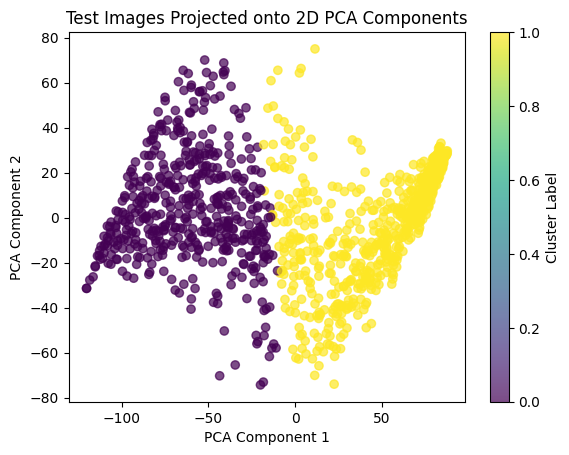

In [115]:
import matplotlib.pyplot as plt

# Reduce to 2 PCA components for visualization
pca_2d = PCA(n_components=2)
images_2d = pca_2d.fit_transform(test_images)

plt.scatter(images_2d[:, 0], images_2d[:, 1], c=predictions, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.title('Test Images Projected onto 2D PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [116]:
# Ensure the PCA transformation on test images
pca_data = model.pca.transform(test_images)  # Re-transform test images


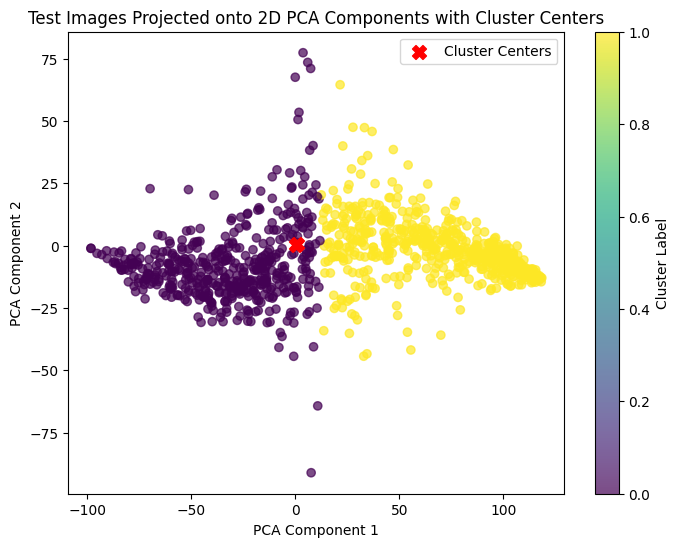

In [117]:
# Plotting with cluster centers
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=predictions, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")

# Plot cluster centers
cluster_centers = model.kmeans.cluster_centers_
pca_centers = model.pca.inverse_transform(cluster_centers)  # Get PCA-space centers
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', marker='X', s=100, label='Cluster Centers')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Test Images Projected onto 2D PCA Components with Cluster Centers")
plt.legend()
plt.show()


In [118]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(pca_data, predictions)
plt.figtext(0.15, -0.05, f'Silhouette Score: {silhouette_avg:.2f}', fontsize=12, color='blue')


Text(0.15, -0.05, 'Silhouette Score: 0.39')

<Figure size 640x480 with 0 Axes>

Text(0, 0.5, 'PCA Component 2 (5.55% Variance)')

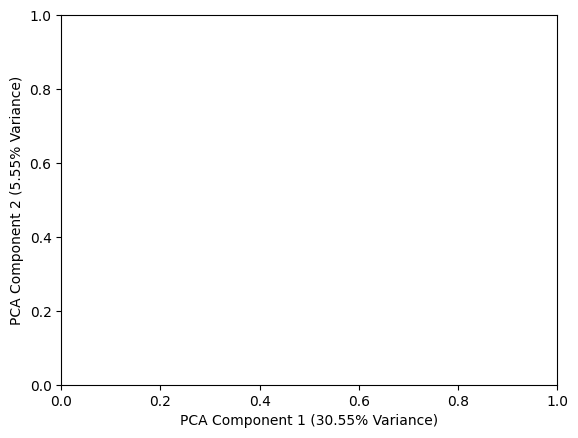

In [119]:
explained_variance = model.pca.explained_variance_ratio_
plt.xlabel(f"PCA Component 1 ({explained_variance[0]*100:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance[1]*100:.2f}% Variance)")


In [120]:
# Save the plot
plot_path = os.path.join(OUTPUT_DIR, "pca_clusters_with_centers.png")
plt.savefig(plot_path)
logger.info(f"Plot saved to {plot_path}")


INFO:ExtremismDetection:Plot saved to /content/drive/MyDrive/EXTREMISM_MODEL/output/pca_clusters_with_centers.png


<Figure size 640x480 with 0 Axes>

In [121]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculate metrics
silhouette_avg = silhouette_score(pca_data, predictions)
calinski_harabasz = calinski_harabasz_score(pca_data, predictions)
davies_bouldin = davies_bouldin_score(pca_data, predictions)

# Load the existing predictions CSV
predictions_csv_path = os.path.join(OUTPUT_DIR, "predictions.csv")
predictions_df = pd.read_csv(predictions_csv_path)

# Add new columns for metrics
predictions_df['Silhouette Score'] = silhouette_avg
predictions_df['Calinski-Harabasz Score'] = calinski_harabasz
predictions_df['Davies-Bouldin Score'] = davies_bouldin

# Save the updated CSV
updated_csv_path = os.path.join(OUTPUT_DIR, "updated_predictions.csv")
predictions_df.to_csv(updated_csv_path, index=False)
logger.info(f"Updated predictions CSV saved to {updated_csv_path}")


INFO:ExtremismDetection:Updated predictions CSV saved to /content/drive/MyDrive/EXTREMISM_MODEL/output/updated_predictions.csv


In [150]:
import pickle

model_path = '/content/drive/MyDrive/EXTREMISM_MODEL/models/extremism_detection_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)


In [151]:
# Save model
model_path = '/content/drive/MyDrive/EXTREMISM_MODEL/models/extremism_detection_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Save updated CSV
updated_csv_path = os.path.join(OUTPUT_DIR, "updated_predictions.csv")
predictions_df.to_csv(updated_csv_path, index=False)


In [96]:
from google.colab import files

files.download(updated_csv_path)
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [66]:
import os

# List all files in the source directory to verify
source_dir = "/content/drive/MyDrive/EXTREMISM_MODEL/"
files_in_source = os.listdir(source_dir)
print("Files in source directory:", files_in_source)


Files in source directory: ['Test_data.zip', 'Training_data.zip', 'data', 'models', 'output', 'logs']


In [159]:
import os

# Check the contents of the models and output directories
models_dir = "/content/drive/MyDrive/EXTREMISM_MODEL/models"
output_dir = "/content/drive/MyDrive/EXTREMISM_MODEL/output"

print("Files in models directory:", os.listdir(models_dir))
print("Files in output directory:", os.listdir(output_dir))


Files in models directory: ['extremism_detection_model.pkl']
Files in output directory: ['predictions.csv', 'updated_predictions.csv', 'pca_clusters_with_centers.png']


In [160]:
import os
import pickle
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import os
import pickle
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

IMAGE_SIZE = (128, 128)
MODEL_PATH = '/content/drive/MyDrive/EXTREMISM_MODEL/models/extremism'


In [161]:
import os
import pickle
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Set up paths
IMAGE_SIZE = (128, 128)
MODEL_PATH = '/content/drive/MyDrive/EXTREMISM_MODEL/models/extremism_detection_model.pkl'
TEST_DIR = '/content/drive/MyDrive/EXTREMISM_MODEL/data/test'
OUTPUT_CSV_PATH = '/content/drive/MyDrive/EXTREMISM_MODEL/output/predictions.csv'
UPDATED_CSV_PATH = '/content/drive/MyDrive/EXTREMISM_MODEL/output/updated_predictions.csv'

# Load model
with open(MODEL_PATH, 'rb') as f:
    model = pickle.load(f)

# Preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, IMAGE_SIZE)
    img = img.astype(np.float64) / 255.0  # Normalize and convert to float64 for compatibility
    return img.flatten()

def load_and_preprocess_images(directory):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)
            filenames.append(filename)
    return np.array(images), filenames

# Generate predictions
test_images, test_filenames = load_and_preprocess_images(TEST_DIR)
predictions = model.predict(test_images)

# Save predictions to CSV
def save_predictions_to_csv(predictions, filenames, output_csv):
    image_ids = [os.path.splitext(filename)[0] for filename in filenames]
    df = pd.DataFrame({'image_id': image_ids, 'prediction_label': predictions})
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

save_predictions_to_csv(predictions, test_filenames, OUTPUT_CSV_PATH)

# Calculate clustering metrics and update the CSV
silhouette_avg = silhouette_score(test_images, predictions)
calinski_harabasz = calinski_harabasz_score(test_images, predictions)
davies_bouldin = davies_bouldin_score(test_images, predictions)

# Append metrics to predictions CSV
df = pd.read_csv(OUTPUT_CSV_PATH)
df['Silhouette Score'] = silhouette_avg
df['Calinski-Harabasz Score'] = calinski_harabasz
df['Davies-Bouldin Score'] = davies_bouldin
df.to_csv(UPDATED_CSV_PATH, index=False)
print(f"Updated predictions with metrics saved to {UPDATED_CSV_PATH}")


Predictions saved to /content/drive/MyDrive/EXTREMISM_MODEL/output/predictions.csv
Updated predictions with metrics saved to /content/drive/MyDrive/EXTREMISM_MODEL/output/updated_predictions.csv


In [131]:
# Check predictions CSV
predictions_df = pd.read_csv('/content/drive/MyDrive/EXTREMISM_MODEL/output/predictions.csv')
print("Predictions CSV Sample:")
print(predictions_df.head())

# Check updated predictions CSV with metrics
updated_predictions_df = pd.read_csv('/content/drive/MyDrive/EXTREMISM_MODEL/output/updated_predictions.csv')
print("\nUpdated Predictions CSV Sample with Metrics:")
print(updated_predictions_df.head())


Predictions CSV Sample:
                                      image_id  prediction_label
0                         pitbull_f00f22ec4c 2                 1
1                          irminsul_c09ee27cda                 1
2                        lorraine_a8a8c14bac 3                 1
3  JzwDeh51bRgPtC_1o2GqknkMwZN0KSXKXCC4mhKmQ94                 0
4  PKUYkE7dtbMpvbrDdL4hlr0KMb4mNOlTjSmP0qD7aTg                 1

Updated Predictions CSV Sample with Metrics:
                                      image_id  prediction_label  \
0                         pitbull_f00f22ec4c 2                 1   
1                          irminsul_c09ee27cda                 1   
2                        lorraine_a8a8c14bac 3                 1   
3  JzwDeh51bRgPtC_1o2GqknkMwZN0KSXKXCC4mhKmQ94                 0   
4  PKUYkE7dtbMpvbrDdL4hlr0KMb4mNOlTjSmP0qD7aTg                 1   

   Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score  
0          0.288003               544.846514              1.38

In [130]:
# Create or open a new inference_script.py file in the specified location
inference_script_content = '''
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import cv2

# Configuration
IMAGE_SIZE = (128, 128)
MODEL_PATH = "models/extremism_detection_model.pkl"  # Relative path inside repo
OUTPUT_CSV_PATH = "output/predictions.csv"           # Relative path inside repo

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, IMAGE_SIZE)
    img = img.astype(np.float32) / 255.0
    return img.flatten()

def load_and_preprocess_images(directory):
    images, filenames = [], []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        processed_image = preprocess_image(image_path)
        if processed_image is not None:
            images.append(processed_image)
            filenames.append(filename)
    return np.array(images), filenames

def generate_predictions():
    # Load model
    with open(MODEL_PATH, 'rb') as f:
        model = pickle.load(f)

    # Load and preprocess test images
    test_images, test_filenames = load_and_preprocess_images("data/test")  # Modify if needed

    # Generate predictions
    predictions = model.predict(test_images)

    # Save predictions to CSV
    image_ids = [os.path.splitext(f)[0] for f in test_filenames]
    df = pd.DataFrame({"image_id": image_ids, "prediction_label": predictions})
    df.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"Predictions saved to {OUTPUT_CSV_PATH}")

if __name__ == "__main__":
    generate_predictions()
'''

# Write to the inference_script.py file
with open("/content/drive/MyDrive/EXTREMISM_MODEL/inference_script.py", "w") as f:
    f.write(inference_script_content)
print("inference_script.py created successfully.")


inference_script.py created successfully.


In [153]:
import os
import shutil

# Define paths
submission_dir = "/content/submission_files"
source_model_dir = "/content/drive/MyDrive/EXTREMISM_MODEL/models"
source_output_dir = "/content/drive/MyDrive/EXTREMISM_MODEL/output"
inference_script_path = "/content/drive/MyDrive/EXTREMISM_MODEL/inference_script.py"  # Update if needed

# Specific paths for each file
model_path = os.path.join(source_model_dir, "extremism_detection_model.pkl")
predictions_csv_path = os.path.join(source_output_dir, "predictions.csv")
updated_predictions_csv_path = os.path.join(source_output_dir, "updated_predictions.csv")

# Create the submission directory if it doesn't exist
os.makedirs(submission_dir, exist_ok=True)

# Copy each required file to the submission folder
shutil.copy(model_path, submission_dir)
shutil.copy(predictions_csv_path, submission_dir)
shutil.copy(updated_predictions_csv_path, submission_dir)
shutil.copy(inference_script_path, submission_dir)  # Ensure this script path is correct

print("All required files copied successfully to the submission directory.")


All required files copied successfully to the submission directory.


In [154]:
import shutil

# Define the zip path
submission_zip_path = "/content/submission_files.zip"

# Zip the submission folder
shutil.make_archive(submission_zip_path.replace(".zip", ""), 'zip', submission_dir)
print(f"Submission zipped at: {submission_zip_path}")


Submission zipped at: /content/submission_files.zip


In [158]:
from google.colab import files

# Download the zip file
files.download(submission_zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
!git config --global user.name tuesdaythe13th
!git config --global user.email pentatholpictures@gmail.com


In [140]:
%cd /content/drive/MyDrive/EXTREMISM_MODEL


/content/drive/MyDrive/EXTREMISM_MODEL


In [162]:
!git init
!git remote add origin https://github.com/Tuesdaythe13th/extremism2.git


Reinitialized existing Git repository in /content/drive/MyDrive/EXTREMISM_MODEL/.git/
error: remote origin already exists.


In [156]:
# Change to the directory where your project is located
%cd /content/drive/MyDrive/EXTREMISM_MODEL

# Initialize the Git repository
!git init

# Add the GitHub repository as the origin
!git remote add origin https://github.com/Tuesdaythe13th/extremism2.git


/content/drive/MyDrive/EXTREMISM_MODEL
Reinitialized existing Git repository in /content/drive/MyDrive/EXTREMISM_MODEL/.git/
error: remote origin already exists.
